# LSTM Model Evaluation

3/25/2020  
by Alexander Chkodrov  



In [1]:
import keras
from keras.models import load_model
from keras.models import model_from_json
from sklearn.metrics import roc_curve, auc
import numpy as np
import os
import h5py
import yaml
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Load Model

In [47]:
from collections import namedtuple
Option = namedtuple("MyStruct", "inputModel inputFile tree config jsonModel outputDir")

options = Option(
    inputModel = 'KERAS_lstm_model_weights.h5',
    inputFile = '../processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth_0.z',
    tree = 't_allpar_new',
    config = 'train_config_lstm.yml',
    jsonModel = 'KERAS_lstm_model.json',
    outputDir = '/output'
)

print("Loading configuration from", options.config)
config = open(options.config, 'r')
yamlConfig =  yaml.load(config, Loader=yaml.FullLoader)
yamlConfig

Loading configuration from train_config_lstm.yml


{'Inputs': ['j1_ptrel',
  'j1_etarot',
  'j1_phirot',
  'j1_erel',
  'j1_deltaR',
  'j1_pdgid',
  'j_index'],
 'Labels': ['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index'],
 'KerasModel': 'lstm_model',
 'KerasModelRetrain': 'lstm_model_constraint',
 'KerasLoss': 'categorical_crossentropy',
 'L1Reg': 0.0001,
 'L1RegR': 0.001,
 'NormalizeInputs': 1,
 'InputType': 'Conv1D',
 'MaxParticles': 20}

In [3]:
json_file = open(options.jsonModel, 'r')
model = model_from_json(json_file.read())
json_file.close()

model.load_weights(options.inputModel)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 6)             0         
_________________________________________________________________
lstm_lstm (LSTM)             (None, 20, 16)            1472      
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
rnn_densef (Dense)           (None, 5)                 1605      
Total params: 3,077
Trainable params: 3,077
Non-trainable params: 0
_________________________________________________________________


## Load Test Data

Input type conv1d; train.py method includes conv1d transformation in get_features method

In [4]:
def get_features(options, yamlConfig, test_size):
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler

    # To use one data file:
    h5File = h5py.File(options.inputFile, 'r')
    treeArray = h5File[options.tree][()]

    print(treeArray.shape)
    #print(treeArray.dtype.names)
    
    # List of features to use
    features = yamlConfig['Inputs']
    
    # List of labels to use
    labels = yamlConfig['Labels']

    # Convert to dataframe
    features_labels_df = pd.DataFrame(treeArray,columns=list(set(features+labels)))
    features_labels_df = features_labels_df.drop_duplicates()

    features_df = features_labels_df[features]
    labels_df = features_labels_df[labels]
    
    print(features_df.head())
    print(labels_df.head())
    
    if 'Conv' in yamlConfig['InputType']:
        labels_df = labels_df.drop_duplicates()
        
    # Convert to numpy array 
    features_val = features_df.values
    labels_val = labels_df.values     

    if 'j_index' in features:
        features_val = features_val[:,:-1] # drop the j_index feature
    if 'j_index' in labels:
        labels_val = labels_val[:,:-1] # drop the j_index label
        print(labels_val.shape)

    if yamlConfig['InputType']=='Conv1D':
        features_2dval = np.zeros((len(labels_df), yamlConfig['MaxParticles'], len(features)-1))
        for i in range(0, len(labels_df)):
            features_df_i = features_df[features_df['j_index']==labels_df['j_index'].iloc[i]]
            index_values = features_df_i.index.values
            #features_val_i = features_val[index_values[0]:index_values[-1]+1,:-1] # drop the last feature j_index
            features_val_i = features_val[np.array(index_values),:]
            nParticles = len(features_val_i)
            #print("before", features_val_i[:,0])
            features_val_i = features_val_i[features_val_i[:,0].argsort()[::-1]] # sort descending by first value (ptrel, usually)
            #print("after", features_val_i[:,0])
            if nParticles>yamlConfig['MaxParticles']:
                features_val_i =  features_val_i[0:yamlConfig['MaxParticles'],:]
            else:        
                features_val_i = np.concatenate([features_val_i, np.zeros((yamlConfig['MaxParticles']-nParticles, len(features)-1))])
            features_2dval[i, :, :] = features_val_i

        features_val = features_2dval

    X_train_val, X_test, y_train_val, y_test = train_test_split(features_val, labels_val, test_size=test_size, random_state=42)
    
    #Normalize conv inputs
    if yamlConfig['NormalizeInputs'] and yamlConfig['InputType']=='Conv1D':
        reshape_X_train_val = X_train_val.reshape(X_train_val.shape[0]*X_train_val.shape[1],X_train_val.shape[2])
        scaler = StandardScaler().fit(reshape_X_train_val)
        for p in range(X_train_val.shape[1]):
            X_train_val[:,p,:] = scaler.transform(X_train_val[:,p,:])
            X_test[:,p,:] = scaler.transform(X_test[:,p,:])    

    if 'j_index' in labels:
        labels = labels[:-1]

    return X_train_val, X_test, y_train_val, y_test, labels

In [5]:
X_train_val, X_test, y_train_val, y_test, labels  = get_features(options, yamlConfig, test_size=0.99)

(5131613,)
   j1_ptrel  j1_etarot  j1_phirot   j1_erel  j1_deltaR  j1_pdgid  j_index
0  0.386118   0.000000   0.000000  0.382772   0.011056     130.0   101333
1  0.107734  -0.009859   0.007236  0.105703   0.023104     211.0   101333
2  0.094731   0.004508  -0.002759  0.094339   0.006306     321.0   101333
3  0.042086   0.028567  -0.014909  0.042913   0.022473     211.0   101333
4  0.039412  -0.018020  -0.003745  0.038547   0.025492    -211.0   101333
   j_g  j_q  j_w  j_z  j_t  j_index
0    1    0    0    0    0   101333
1    1    0    0    0    0   101333
2    1    0    0    0    0   101333
3    1    0    0    0    0   101333
4    1    0    0    0    0   101333
(98769, 5)


In [6]:
X_test.shape #99% of dataset is retained as training set

(97782, 20, 6)

In [7]:
y_test.shape

(97782, 5)

## Run Inference & Evaluate

In [44]:
def makeRoc(features_val, labels, labels_val, model, outputDir, outputFile=''):
    if 'j_index' in labels: labels.remove('j_index')
    predict_test = model.predict(features_val)
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure()       
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = predict_test[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot([0, 1], [0, 1], lw=1, color='navy', linestyle='--')
    plt.semilogy()
    plt.xlabel("Signal Efficiency")
    plt.ylabel("Background Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'LSTM ROC Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    plt.savefig('%s/ROC%s.pdf'%(outputDir, outputFile))
    return predict_test

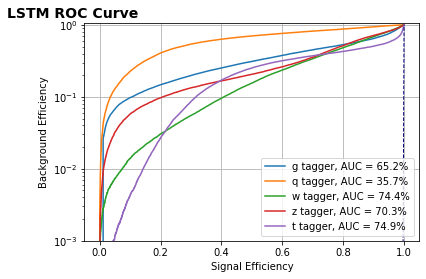

In [9]:
y_pred = makeRoc(X_test, labels, y_test, model, os.curdir, '_preloaded')

## Retrain Model

In [10]:
X_train_val, X_test, y_train_val, y_test, labels  = get_features(options, yamlConfig, test_size=0.2)

(5131613,)
   j1_ptrel  j1_etarot  j1_phirot   j1_erel  j1_deltaR  j1_pdgid  j_index
0  0.386118   0.000000   0.000000  0.382772   0.011056     130.0   101333
1  0.107734  -0.009859   0.007236  0.105703   0.023104     211.0   101333
2  0.094731   0.004508  -0.002759  0.094339   0.006306     321.0   101333
3  0.042086   0.028567  -0.014909  0.042913   0.022473     211.0   101333
4  0.039412  -0.018020  -0.003745  0.038547   0.025492    -211.0   101333
   j_g  j_q  j_w  j_z  j_t  j_index
0    1    0    0    0    0   101333
1    1    0    0    0    0   101333
2    1    0    0    0    0   101333
3    1    0    0    0    0   101333
4    1    0    0    0    0   101333
(98769, 5)


In [22]:
from keras.optimizers import Adam, Nadam

In [50]:
adam = Adam(lr=yamlConfig['L1Reg'])

In [25]:
model.compile(optimizer=adam, loss=[yamlConfig['KerasLoss']], metrics=['accuracy'])

In [26]:
history = model.fit(X_train_val, y_train_val, batch_size = 1024, epochs = 100,
                      validation_split = 0.25, shuffle = True)

Train on 59261 samples, validate on 19754 samples
Epoch 1/100
59261/59261 [==============================] - 2s 35us/step - loss: 0.8988 - accuracy: 0.7025 - val_loss: 0.9080 - val_accuracy: 0.6977
Epoch 2/100
59261/59261 [==============================] - 2s 25us/step - loss: 0.8985 - accuracy: 0.7028 - val_loss: 0.9071 - val_accuracy: 0.6983
Epoch 3/100
59261/59261 [==============================] - 1s 24us/step - loss: 0.8978 - accuracy: 0.7025 - val_loss: 0.9064 - val_accuracy: 0.7002
Epoch 4/100
59261/59261 [==============================] - 1s 23us/step - loss: 0.8973 - accuracy: 0.7028 - val_loss: 0.9048 - val_accuracy: 0.6998
Epoch 5/100
59261/59261 [==============================] - 1s 24us/step - loss: 0.8968 - accuracy: 0.7032 - val_loss: 0.9050 - val_accuracy: 0.7001
Epoch 6/100
59261/59261 [==============================] - 1s 23us/step - loss: 0.8963 - accuracy: 0.7033 - val_loss: 0.9043 - val_accuracy: 0.7009
Epoch 7/100
59261/59261 [==============================] - 1s 

Epoch 56/100
59261/59261 [==============================] - 1s 22us/step - loss: 0.8758 - accuracy: 0.7078 - val_loss: 0.8841 - val_accuracy: 0.7041
Epoch 57/100
59261/59261 [==============================] - 1s 22us/step - loss: 0.8753 - accuracy: 0.7076 - val_loss: 0.8836 - val_accuracy: 0.7040
Epoch 58/100
59261/59261 [==============================] - 1s 22us/step - loss: 0.8748 - accuracy: 0.7081 - val_loss: 0.8827 - val_accuracy: 0.7050
Epoch 59/100
59261/59261 [==============================] - 1s 22us/step - loss: 0.8743 - accuracy: 0.7081 - val_loss: 0.8843 - val_accuracy: 0.7044
Epoch 60/100
59261/59261 [==============================] - 1s 21us/step - loss: 0.8743 - accuracy: 0.7077 - val_loss: 0.8829 - val_accuracy: 0.7046
Epoch 61/100
59261/59261 [==============================] - 1s 22us/step - loss: 0.8738 - accuracy: 0.7084 - val_loss: 0.8825 - val_accuracy: 0.7045
Epoch 62/100
59261/59261 [==============================] - 1s 21us/step - loss: 0.8735 - accuracy: 0.7080

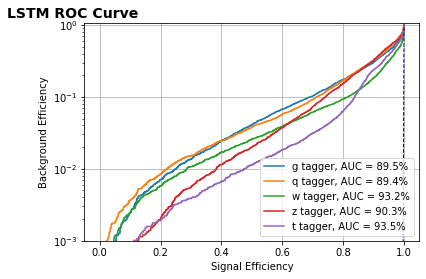

In [45]:
y_pred = makeRoc(X_test, labels, y_test, model, os.curdir, '_trained')

In [29]:
history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

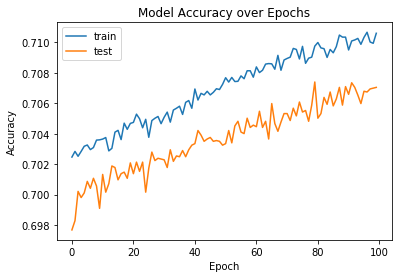

In [41]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','test'])
plt.savefig('%s/Accuracy.pdf'%(os.curdir))
plt.show()

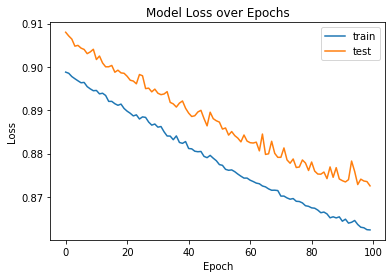

In [42]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','test'])
plt.savefig('%s/Loss.pdf'%(os.curdir))
plt.show()

In [23]:
from train.callbacks import all_callbacks
callbacks=all_callbacks(stop_patience=1000, 
                        lr_factor=0.5,
                        lr_patience=10,
                        lr_epsilon=0.000001, 
                        lr_cooldown=2, 
                        lr_minimum=0.0000001,
                        outputDir=options.outputDir)